In [101]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import label_binarize


In [102]:
# Load the data
crops_df = pd.read_csv('soil_measures.csv')

In [103]:
# View the data
print(crops_df.head())
print(crops_df.shape)

    N   P   K        ph  crop
0  90  42  43  6.502985  rice
1  85  58  41  7.038096  rice
2  60  55  44  7.840207  rice
3  74  35  40  6.980401  rice
4  78  42  42  7.628473  rice
(2200, 5)


In [104]:
# Check for missing values
print(crops_df.isnull().sum().sort_values(ascending=False))

N       0
P       0
K       0
ph      0
crop    0
dtype: int64


In [105]:
# Check for the frequency of each unique value in the 'Crop' column
print(crops_df['crop'].value_counts().sort_values(ascending=False))

crop
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64


In [106]:
# Perfom exploratory data analysis
print(crops_df.describe())

                 N            P            K           ph
count  2200.000000  2200.000000  2200.000000  2200.000000
mean     50.551818    53.362727    48.149091     6.469480
std      36.917334    32.985883    50.647931     0.773938
min       0.000000     5.000000     5.000000     3.504752
25%      21.000000    28.000000    20.000000     5.971693
50%      37.000000    51.000000    32.000000     6.425045
75%      84.250000    68.000000    49.000000     6.923643
max     140.000000   145.000000   205.000000     9.935091


In [107]:
# Split the data into features and target
X = crops_df.drop(['crop'], axis=1)
y = crops_df['crop']

In [108]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)
# Feature set
features = X.columns

# Feature performance
feature_performance = {}

d:\Data\Projects\Machine Learning\Predictive Modeling for Agriculture\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Data\Projects\Machine Learning\Predictive Modeling for Agriculture\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver 

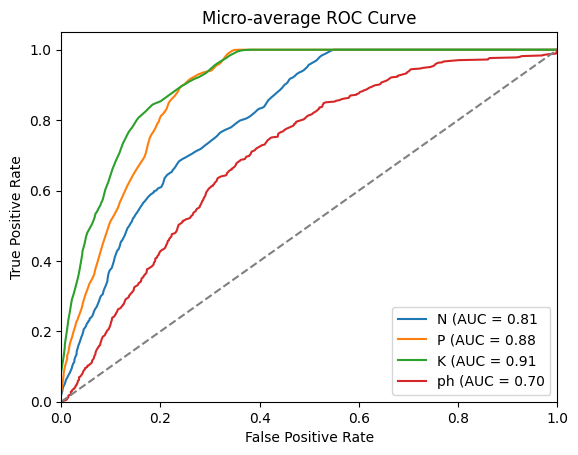

Feature: N, Micro-average ROC AUC: 0.8083766572773908
Feature: P, Micro-average ROC AUC: 0.8836837679701581
Feature: K, Micro-average ROC AUC: 0.9088120806303506
Feature: ph, Micro-average ROC AUC: 0.7049848559974126


In [109]:
# Train the model and calculate the feature performance for each feature
for feature in features:
    model = LogisticRegression(multi_class='multinomial')
    model.fit(X_train[[feature]], y_train)
    y_pred_proba = model.predict_proba(X_test[[feature]])
    
    # Binarize the labels for each class
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    
    # Compute ROC curve and ROC AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(np.unique(y_test))):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(np.unique(y_test)))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(np.unique(y_test))):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(np.unique(y_test))
    fpr_micro = all_fpr
    tpr_micro = mean_tpr
    roc_auc_micro = metrics.auc(fpr_micro, tpr_micro)
    
    # Store micro-average ROC AUC in feature_performance dictionary
    feature_performance[feature] = roc_auc_micro
    
    # Plot micro-average ROC curve
    plt.plot(fpr_micro, tpr_micro, label=f'{feature} (AUC = {roc_auc_micro:.2f}')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print feature performance
for feature, auc_score in feature_performance.items():
    print(f'Feature: {feature}, Micro-average ROC AUC: {auc_score}')

In [113]:
# Best performing feature
best_predictive_feature = {  #
    max(feature_performance, key=feature_performance.get):
    feature_performance[max(feature_performance, key=feature_performance.get)]
}
print(best_predictive_feature)

{'K': 0.9088120806303506}


In [114]:
# Predict the highest yielding crop using the best performing feature
model = LogisticRegression(multi_class='multinomial')
model.fit(X_train[[max(feature_performance, key=feature_performance.get)]],
          y_train)
y_pred = model.predict(
    X_test[[max(feature_performance, key=feature_performance.get)]])
print(f'F1 Score: {metrics.f1_score(y_test, y_pred, average="weighted")}')

F1 Score: 0.25154884877151235


d:\Data\Projects\Machine Learning\Predictive Modeling for Agriculture\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
# Save the model
joblib.dump(model, 'crop_recommendation_model.pkl')


['crop_recommendation_model.pkl']